In [1]:
########################################
# Activity Prediction by Deep Learning #
# @author: A.Prof. Tran Van Lang, PhD  #
# File: usingKeras.py                  #
########################################

import numpy as np
import pandas as pd
import csv
from time import time
from keras.models import Sequential
from keras.layers import Dense, Dropout
#from keras.optimizers import Adam
from keras.optimizers.legacy import Adam
from sklearn.metrics import accuracy_score
from bayes_opt import BayesianOptimization

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE,ADASYN,BorderlineSMOTE
from imblearn.combine import SMOTEENN,SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from visualLang import visualization_proba

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UndefinedMetricWarning)
# Để không xuất lỗi warning của TensorFlow: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
path = 'data/BioassayDatasets/AID373red'
df_train = pd.read_csv( path + '_train.csv')
df_test  = pd.read_csv( path + '_test.csv' )

# Delete the missing values datapoint
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

# Split the dataset into features and labels
X_tr = df_train.drop('Outcome', axis=1)
X_te = df_test.drop('Outcome', axis=1)

y_tr = df_train['Outcome']
y_te = df_test['Outcome']

# Convert the features and labels to NumPy arrays
X_train = np.array(X_tr)
y_train = np.array(y_tr)

X_test = np.array(X_te)
y_test = np.array(y_te)

y_train = np.where(y_train == 'Active', 0, 1)
y_test = np.where(y_test == 'Active', 0, 1)

results = []

In [3]:
################ HUẤN LUYỆN MÔ HÌNH ################

In [4]:
def modelLang(X_train, learning_rate, dropout_rate):
    dropout_rate = 0.3
    learning_rate = 0.0001
    optimizer = Adam(learning_rate=learning_rate)

    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [5]:
def objectiveFunc(learning_rate, dropout_rate):
    model = modelLang(X_train,learning_rate, dropout_rate)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [6]:
def trainLang(X_train,y_train,learning_rate=0.0001,dropout_rate=0.1):
    t0 = time()
    model = modelLang( X_train,learning_rate, dropout_rate ) 
    model.fit(X_train, y_train, epochs=100, verbose=0)
    print( 'Eslaped time: %5.2f seconds' %(time()-t0) )
    return model

def trainBOLang(X_train,y_train):
    t0 = time()
    params = {'learning_rate':(0.0001,0.1),'dropout_rate':(0.1,0.5)}
    optimizer = BayesianOptimization(f=objectiveFunc, pbounds=params)
    optimizer.maximize(init_points=5,n_iter=10)

    # Tìm được các tham số tối ưu để xây dựng mô hình
    opt_learning_rate = optimizer.max['params']['learning_rate']
    opt_dropout_rate = optimizer.max['params']['dropout_rate']

    model = modelLang(X_train,opt_learning_rate, opt_dropout_rate)
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    print( 'Eslaped time: %5.2f seconds' %(time()-t0) )
    return model

def resampleBOLang(estimator,X_train,y_train,X_test,y_test):
    print("Số lượng mẫu sau khi resample để huấn luyện:", len(X_train))
    model = trainBOLang(X_train,y_train)
    estimator,metric,npred = visualization_proba(estimator+str(len(X_train)),model,X_test,y_test)
    return estimator,metric,npred

Số lượng mẫu dùng huấn luyện: 47831
Eslaped time: 51.48 seconds
374/374 [==============================] - 0s 210us/step

               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       1.00      1.00      1.00     11945

    accuracy                           1.00     11957
   macro avg       0.50      0.50      0.50     11957
weighted avg       1.00      1.00      1.00     11957

Loss: 0.009380590170621872
Accuracy: 0.998996376991272
AUC: 0.7921340867866612


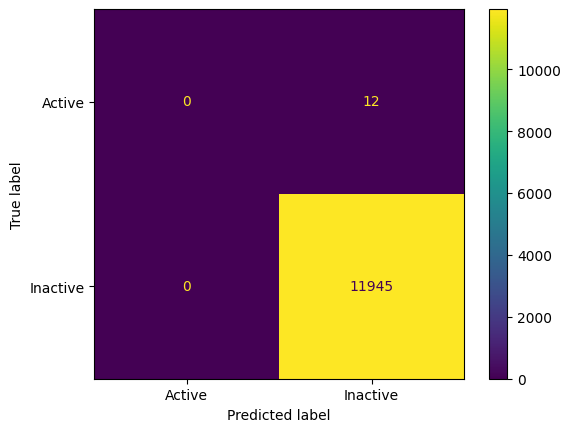

In [7]:
print("Số lượng mẫu dùng huấn luyện:", len(X_train))
model = trainLang(X_train,y_train)

estimator,metric,npred = visualization_proba('DeepLearning_'+str(len(X_train)),model,X_test,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu dùng huấn luyện: 47831
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 209us/step
| 1         | 0.999     | 0.1043    | 0.09204   |
374/374 [==============================] - 0s 213us/step
| 2         | 0.999     | 0.238     | 0.04523   |
374/374 [==============================] - 0s 253us/step
| 3         | 0.999     | 0.1491    | 0.02654   |
374/374 [==============================] - 0s 252us/step
| 4         | 0.999     | 0.4129    | 0.01415   |
374/374 [==============================] - 0s 273us/step
| 5         | 0.999     | 0.1086    | 0.07102   |
374/374 [==============================] - 0s 245us/step
| 6         | 0.999     | 0.4998    | 0.0002561 |
374/374 [==============================] - 0s 255us/step
| 7         | 0.999     | 0.4993    | 0.09738   |
374/374 [==============================] - 0s 262us/step
| 8         | 0.999     | 0.3118    | 0.08584   |
374/374 

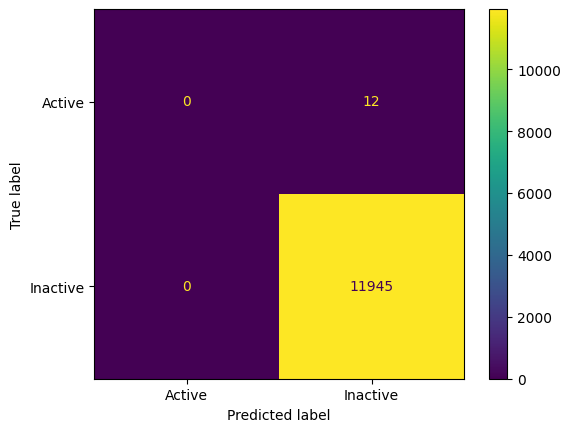

In [8]:
print("Số lượng mẫu dùng huấn luyện:", len(X_train))
model = trainBOLang(X_train,y_train)

estimator,metric,npred = visualization_proba('DeepLearning, BO_'+str(len(X_train)),model,X_test,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

In [9]:
################## XỬ LÝ DỮ LIỆU DÙNG MIN-MAX SCALING ###############

In [10]:
# Xử lý dữ liệu, dùng Min-max scaling để chuyển đổi giá trị dữ liệu về khoảng mong muốn
minmax_scaler = MinMaxScaler()
X_train_mms = minmax_scaler.fit_transform(X_train)
X_test_mms = minmax_scaler.fit_transform(X_test)

Số lượng mẫu dùng huấn luyện: 47831
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 210us/step
| 1         | 0.999     | 0.4       | 0.03862   |
374/374 [==============================] - 0s 212us/step
| 2         | 0.999     | 0.4       | 0.06356   |
374/374 [==============================] - 0s 211us/step
| 3         | 0.999     | 0.3455    | 0.06104   |
374/374 [==============================] - 0s 210us/step
| 4         | 0.999     | 0.4533    | 0.05218   |
374/374 [==============================] - 0s 210us/step
| 5         | 0.999     | 0.221     | 0.009685  |
374/374 [==============================] - 0s 213us/step
| 6         | 0.999     | 0.1005    | 0.09983   |
374/374 [==============================] - 0s 223us/step
| 7         | 0.999     | 0.1001    | 0.0004271 |
374/374 [==============================] - 0s 215us/step
| 8         | 0.999     | 0.1285    | 0.04972   |
374/374 

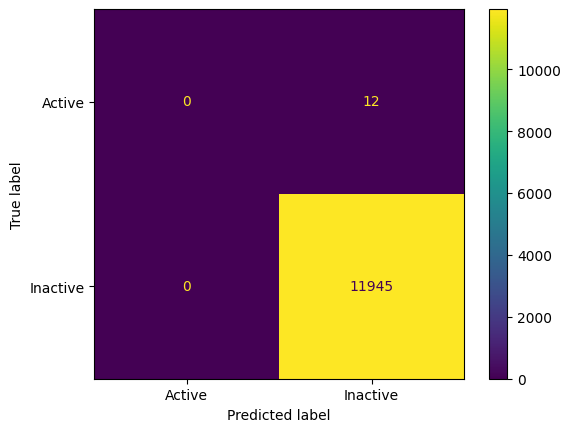

In [11]:
print("Số lượng mẫu dùng huấn luyện:", len(X_train_mms))
model = trainBOLang(X_train_mms,y_train)

estimator,metric,npred = visualization_proba('DeepLearning, Min-Max Scaling, BO_'+str(len(X_train_mms)),model,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

In [12]:
################# RESAMPLING ###################

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 229us/step
| 1         | 0.999     | 0.2647    | 0.08969   |
374/374 [==============================] - 0s 213us/step
| 2         | 0.999     | 0.3175    | 0.03108   |
374/374 [==============================] - 0s 215us/step
| 3         | 0.999     | 0.1737    | 0.03469   |
374/374 [==============================] - 0s 211us/step
| 4         | 0.999     | 0.4785    | 0.05414   |
374/374 [==============================] - 0s 207us/step
| 5         | 0.999     | 0.2451    | 0.02305   |
374/374 [==============================] - 0s 206us/step
| 6         | 0.999     | 0.4996    | 0.004017  |
374/374 [==============================] - 0s 205us/step
| 7         | 0.999     | 0.1006    | 0.09629   |
374/374 [==============================] - 0s 207us/step
| 8         | 0.999     | 0.2575    | 0.041

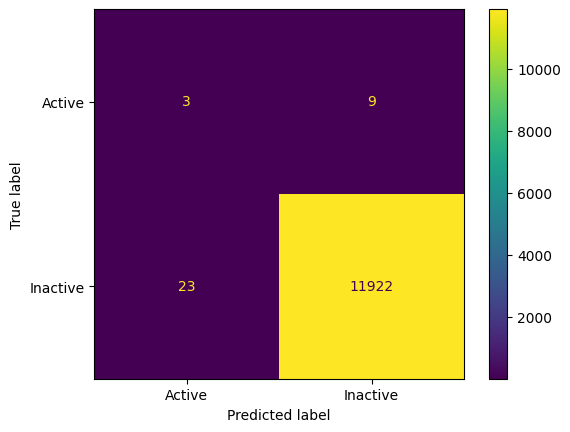

In [13]:
# Sử dụng SMOTE để tăng cường dữ liệu thiểu số
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_mms,y_train)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, SMOTE_',X_train_smote,y_train_smote,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95573
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 212us/step
| 1         | 0.999     | 0.296     | 0.04246   |
374/374 [==============================] - 0s 209us/step
| 2         | 0.999     | 0.4954    | 0.06799   |
374/374 [==============================] - 0s 212us/step
| 3         | 0.999     | 0.4375    | 0.02922   |
374/374 [==============================] - 0s 209us/step
| 4         | 0.999     | 0.1011    | 0.0446    |
374/374 [==============================] - 0s 209us/step
| 5         | 0.999     | 0.3077    | 0.05525   |
374/374 [==============================] - 0s 213us/step
| 6         | 0.999     | 0.1003    | 0.09262   |
374/374 [==============================] - 0s 223us/step
| 7         | 0.999     | 0.4993    | 0.0009557 |
374/374 [==============================] - 0s 221us/step
| 8         | 0.999     | 0.3903    | 0.077

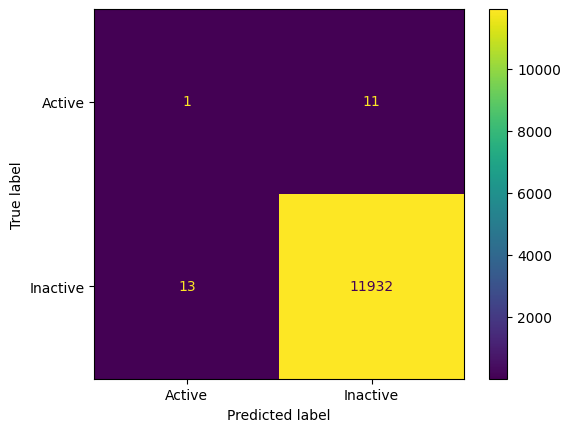

In [14]:
# Sử dụng ADASYN để tăng cường dữ liệu thiểu số
adasyn = ADASYN()
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_mms,y_train)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, ADASYN_',X_train_adasyn,y_train_adasyn,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 210us/step
| 1         | 0.999     | 0.4671    | 0.02276   |
374/374 [==============================] - 0s 209us/step
| 2         | 0.999     | 0.1705    | 0.03762   |
374/374 [==============================] - 0s 209us/step
| 3         | 0.999     | 0.163     | 0.0855    |
374/374 [==============================] - 0s 207us/step
| 4         | 0.999     | 0.3188    | 0.01683   |
374/374 [==============================] - 0s 207us/step
| 5         | 0.999     | 0.4824    | 0.01181   |
374/374 [==============================] - 0s 210us/step
| 6         | 0.999     | 0.1004    | 0.09453   |
374/374 [==============================] - 0s 210us/step
| 7         | 0.999     | 0.5       | 0.09428   |
374/374 [==============================] - 0s 208us/step
| 8         | 0.999     | 0.3263    | 0.089

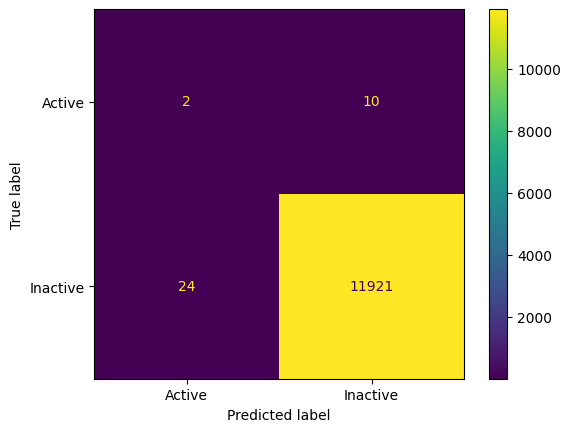

In [15]:
# Sử dụng Borderline-SMOTE để tăng cường dữ liệu thiểu số
borderline_smote = BorderlineSMOTE()
X_train_borderline, y_train_borderline = borderline_smote.fit_resample(X_train_mms,y_train)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, BorderlineSMOTE_',X_train_borderline,y_train_borderline,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95307
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 208us/step
| 1         | 0.999     | 0.4401    | 0.0939    |
374/374 [==============================] - 0s 208us/step
| 2         | 0.999     | 0.3926    | 0.0006102 |
374/374 [==============================] - 0s 207us/step
| 3         | 0.999     | 0.2174    | 0.08425   |
374/374 [==============================] - 0s 210us/step
| 4         | 0.999     | 0.2503    | 0.04039   |
374/374 [==============================] - 0s 209us/step
| 5         | 0.999     | 0.2494    | 0.04316   |
374/374 [==============================] - 0s 208us/step
| 6         | 0.999     | 0.1008    | 0.001495  |
374/374 [==============================] - 0s 206us/step
| 7         | 0.999     | 0.4986    | 0.09882   |
374/374 [==============================] - 0s 221us/step
| 8         | 0.999     | 0.3565    | 0.065

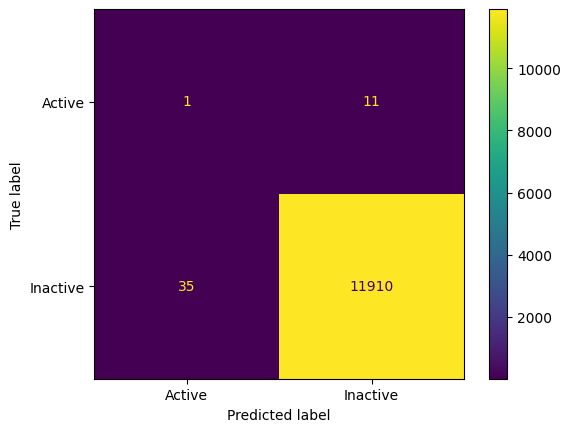

In [16]:
# Sử dụng SMOTE-ENN để kết hợp SMOTE và Edited Nearest Neighbors
smote_enn = SMOTEENN()
X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train_mms, y_train)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, SMOTEENN_',X_train_smoteenn,y_train_smoteenn,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 212us/step
| 1         | 0.999     | 0.3192    | 0.03123   |
374/374 [==============================] - 0s 211us/step
| 2         | 0.999     | 0.1465    | 0.04903   |
374/374 [==============================] - 0s 205us/step
| 3         | 0.999     | 0.4452    | 0.02996   |
374/374 [==============================] - 0s 203us/step
| 4         | 0.999     | 0.1521    | 0.01657   |
374/374 [==============================] - 0s 205us/step
| 5         | 0.999     | 0.2177    | 0.07256   |
374/374 [==============================] - 0s 208us/step
| 6         | 0.999     | 0.4991    | 0.09889   |
374/374 [==============================] - 0s 208us/step
| 7         | 0.999     | 0.4999    | 0.005016  |
374/374 [==============================] - 0s 203us/step
| 8         | 0.999     | 0.331     | 0.073

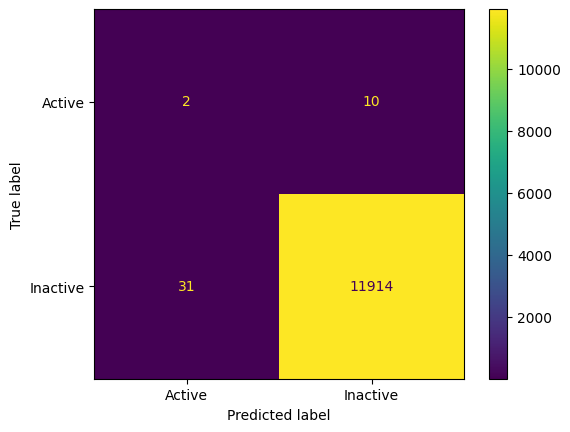

In [17]:
# Sử dụng Random Oversampling để tăng cường dữ liệu thiểu số
random_oversampler = RandomOverSampler()
X_train_random, y_train_random = random_oversampler.fit_resample(X_train_mms, y_train)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, RandomOverSamples_',X_train_random,y_train_random,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 100
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 210us/step
| 1         | 0.999     | 0.1019    | 0.01072   |
374/374 [==============================] - 0s 210us/step
| 2         | 0.999     | 0.4043    | 0.07139   |
374/374 [==============================] - 0s 221us/step
| 3         | 0.999     | 0.3057    | 0.08025   |
374/374 [==============================] - 0s 210us/step
| 4         | 0.999     | 0.1678    | 0.09822   |
374/374 [==============================] - 0s 210us/step
| 5         | 0.999     | 0.3523    | 0.01398   |
374/374 [==============================] - 0s 207us/step
| 6         | 0.999     | 0.4989    | 0.001057  |
374/374 [==============================] - 0s 208us/step
| 7         | 0.999     | 0.1013    | 0.09866   |
374/374 [==============================] - 0s 209us/step
| 8         | 0.999     | 0.1123    | 0.03607

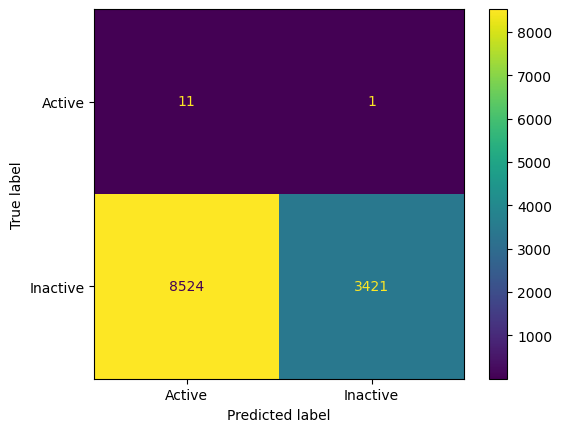

In [18]:
# Sử dụng Random Undersampling để giảm dữ liệu đa số
random_undersampler = RandomUnderSampler()
X_train_random, y_train_random = random_undersampler.fit_resample(X_train_mms, y_train)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, RandomUnderSamples_',X_train_random,y_train_random,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 205us/step
| 1         | 0.999     | 0.2198    | 0.01005   |
374/374 [==============================] - 0s 214us/step
| 2         | 0.999     | 0.2287    | 0.01137   |
374/374 [==============================] - 0s 204us/step
| 3         | 0.999     | 0.3016    | 0.0416    |
374/374 [==============================] - 0s 206us/step
| 4         | 0.999     | 0.4534    | 0.04242   |
374/374 [==============================] - 0s 205us/step
| 5         | 0.999     | 0.3606    | 0.03908   |
374/374 [==============================] - 0s 208us/step
| 6         | 0.999     | 0.1009    | 0.09775   |
374/374 [==============================] - 0s 207us/step
| 7         | 0.999     | 0.4991    | 0.09989   |
374/374 [==============================] - 0s 207us/step
| 8         | 0.999     | 0.3065    | 0.093

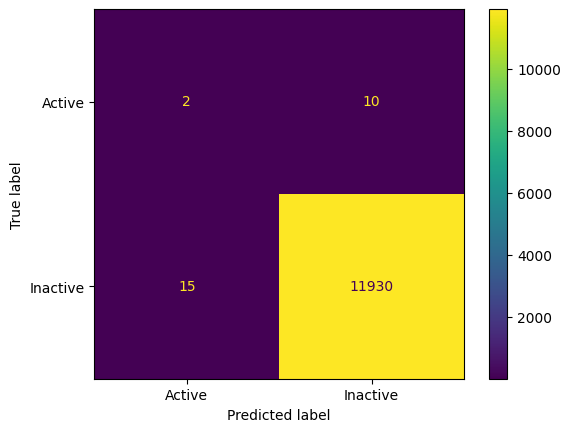

In [19]:
# Áp dụng phương pháp SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_mms, y_train)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, SMOTETomek_',X_train_smotetomek,y_train_smotetomek,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

In [20]:
############### DÙNG KỸ THUẬT GAN ####################

In [21]:
def augmentLang( X_train, y_train, batch_size=32, epochs=50 ):
    # Số lượng nhãn thiểu số và đa số
    count_minority = np.sum(y_train == 0)
    count_majority = np.sum(y_train == 1)
    dim = X_train.shape[1]

    # Tạo mô hình GAN
    generator = Sequential()
    generator.add(Dense(32, input_dim=dim, activation='relu'))
    generator.add(Dense(dim, activation='sigmoid'))
    generator.compile(loss='binary_crossentropy', optimizer=Adam())

    discriminator = Sequential()
    discriminator.add(Dense(32, input_dim=dim, activation='relu', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(Dense(1, activation='sigmoid', kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    gan = Sequential()
    gan.add(generator)
    gan.add(discriminator)
    gan.compile(loss='binary_crossentropy', optimizer=Adam())

    # Huấn luyện GAN
    for epoch in range(epochs):
        # Tạo mẫu dữ liệu giả tạo
        random_noise = np.random.normal(0, 1, size=[count_minority,dim])
        generated_data = generator.predict(random_noise)

        # Kết hợp dữ liệu thật và giả tạo
        X_combined = np.concatenate([X_train, generated_data])
        y_combined = np.concatenate([y_train, np.zeros(count_minority)])

        # Huấn luyện bộ phân biệt
        discriminator.trainable = True
        discriminator.fit(X_combined, y_combined, batch_size=batch_size, epochs=1, verbose=0)

        # Huấn luyện bộ sinh
        discriminator.trainable = False
        gan.fit(random_noise, np.ones(count_minority), batch_size=batch_size, epochs=1, verbose=0)
    
    # Tạo dữ liệu mới từ bộ sinh đã đào tạo
    random_noise = np.random.normal(0, 1, size=[count_minority, X_train.shape[1]])
    generated_data = generator.predict(random_noise)

    # Kết hợp dữ liệu mới và gốc
    X_augmented = np.concatenate([X_train, generated_data])
    y_augmented = np.concatenate([y_train, np.zeros(count_minority)])
    return X_augmented, y_augmented

In [22]:
from tensorflow.keras import initializers

print( 'Số mẫu của 2 nhãn là: ',np.sum(y_train==0),np.sum(y_train==1) )
X_train_gan, y_train_gan = augmentLang( X_train_mms, y_train )

Số mẫu của 2 nhãn là:  50 47781
2/2 [==============================] - 0s 688us/step


Eslaped time: 50.73 seconds
374/374 [==============================] - 0s 207us/step

               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       1.00      1.00      1.00     11945

    accuracy                           1.00     11957
   macro avg       0.50      0.50      0.50     11957
weighted avg       1.00      1.00      1.00     11957

Loss: 0.010588608682155609
Accuracy: 0.9989127516746521
AUC: 0.7677445235105342


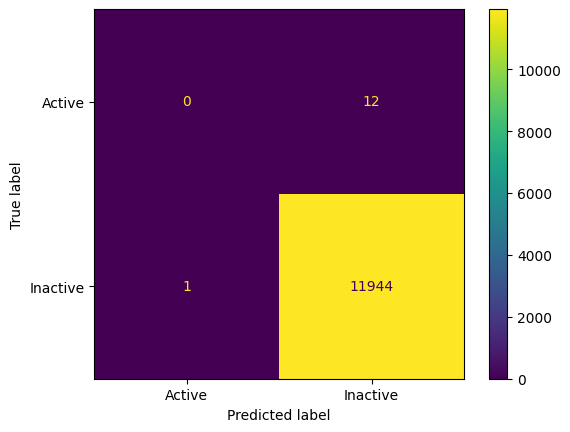

In [23]:
model = trainLang(X_train_gan, y_train_gan)
estimator,metric,npred = visualization_proba('DeepLearning, GAN_'+str(len(X_train_gan)),model,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 204us/step
| 1         | 0.999     | 0.3141    | 0.07694   |
374/374 [==============================] - 0s 208us/step
| 2         | 0.999     | 0.1255    | 0.07528   |
374/374 [==============================] - 0s 208us/step
| 3         | 0.999     | 0.1997    | 0.06242   |
374/374 [==============================] - 0s 213us/step
| 4         | 0.999     | 0.4153    | 0.02079   |
374/374 [==============================] - 0s 208us/step
| 5         | 0.999     | 0.2787    | 0.03311   |
374/374 [==============================] - 0s 220us/step
| 6         | 0.999     | 0.5       | 0.001924  |
374/374 [==============================] - 0s 220us/step
| 7         | 0.999     | 0.1005    | 0.09931   |
374/374 [==============================] - 0s 258us/step
| 8         | 0.999     | 0.2245    | 0.057

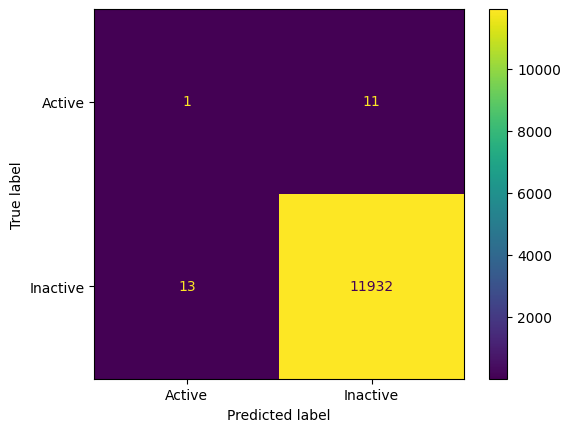

In [24]:
# Sử dụng SMOTE để tăng cường dữ liệu thiểu số
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_gan,y_train_gan)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, GAN, SMOTE_',X_train_smote,y_train_smote,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 209us/step
| 1         | 0.999     | 0.2775    | 0.03774   |
374/374 [==============================] - 0s 206us/step
| 2         | 0.999     | 0.4058    | 0.05342   |
374/374 [==============================] - 0s 208us/step
| 3         | 0.999     | 0.4688    | 0.04108   |
374/374 [==============================] - 0s 209us/step
| 4         | 0.999     | 0.2197    | 0.01439   |
374/374 [==============================] - 0s 206us/step
| 5         | 0.999     | 0.1542    | 0.07302   |
374/374 [==============================] - 0s 209us/step
| 6         | 0.999     | 0.1       | 0.09755   |
374/374 [==============================] - 0s 208us/step
| 7         | 0.999     | 0.4997    | 0.09729   |
374/374 [==============================] - 0s 209us/step
| 8         | 0.999     | 0.1584    | 0.027

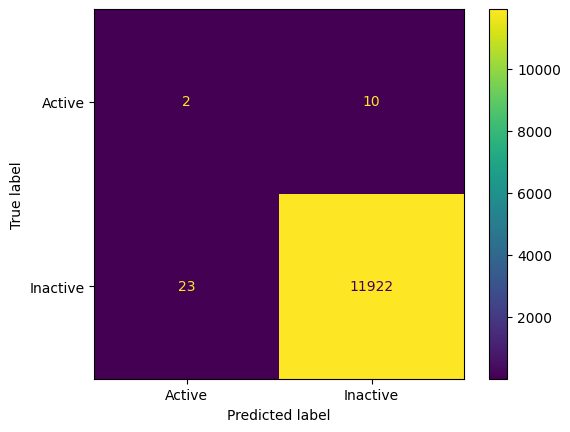

In [25]:
# Sử dụng Borderline-SMOTE để tăng cường dữ liệu thiểu số
borderline_smote = BorderlineSMOTE()
X_train_borderline, y_train_borderline = borderline_smote.fit_resample(X_train_gan,y_train_gan)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, GAN, BorderlineSMOTE_',X_train_borderline,y_train_borderline,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95306
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 222us/step
| 1         | 0.999     | 0.3107    | 0.01253   |
374/374 [==============================] - 0s 255us/step
| 2         | 0.999     | 0.281     | 0.05735   |
374/374 [==============================] - 0s 255us/step
| 3         | 0.999     | 0.1655    | 0.09703   |
374/374 [==============================] - 0s 275us/step
| 4         | 0.999     | 0.2926    | 0.04561   |
374/374 [==============================] - 0s 274us/step
| 5         | 0.999     | 0.422     | 0.04084   |
374/374 [==============================] - 0s 254us/step
| 6         | 0.999     | 0.4993    | 0.0009769 |
374/374 [==============================] - 0s 241us/step
| 7         | 0.999     | 0.1004    | 0.09351   |
374/374 [==============================] - 0s 229us/step
| 8         | 0.999     | 0.4345    | 0.091

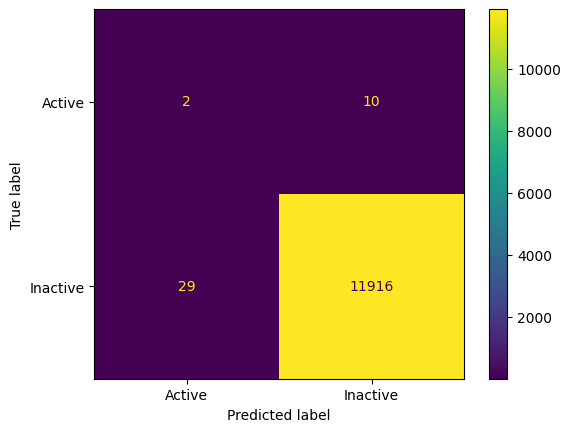

In [26]:
# Sử dụng SMOTE-ENN để kết hợp SMOTE và Edited Nearest Neighbors
smote_enn = SMOTEENN()
X_train_smoteenn, y_train_smoteenn = smote_enn.fit_resample(X_train_gan, y_train_gan)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, GAN, SMOTEENN_',X_train_smoteenn,y_train_smoteenn,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 205us/step
| 1         | 0.999     | 0.2479    | 0.07202   |
374/374 [==============================] - 0s 209us/step
| 2         | 0.999     | 0.1725    | 0.07217   |
374/374 [==============================] - 0s 211us/step
| 3         | 0.999     | 0.1507    | 0.08068   |
374/374 [==============================] - 0s 209us/step
| 4         | 0.999     | 0.4547    | 0.03858   |
374/374 [==============================] - 0s 212us/step
| 5         | 0.999     | 0.4942    | 0.07897   |
374/374 [==============================] - 0s 209us/step
| 6         | 0.999     | 0.1001    | 0.003874  |
374/374 [==============================] - 0s 210us/step
| 7         | 0.999     | 0.4982    | 0.001465  |
374/374 [==============================] - 0s 208us/step
| 8         | 0.999     | 0.2525    | 0.055

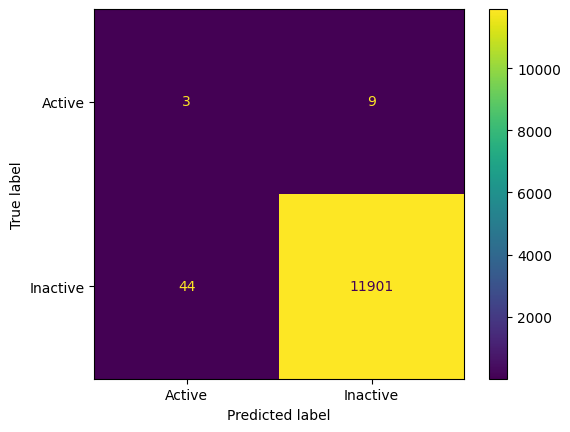

In [27]:
# Sử dụng Random Oversampling để tăng cường dữ liệu thiểu số
random_oversampler = RandomOverSampler()
X_train_random, y_train_random = random_oversampler.fit_resample(X_train_gan, y_train_gan)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, GAN, RandomOverSamples_',X_train_random,y_train_random,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 200
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 208us/step
| 1         | 0.999     | 0.3025    | 0.01141   |
374/374 [==============================] - 0s 213us/step
| 2         | 0.999     | 0.3992    | 0.03029   |
374/374 [==============================] - 0s 208us/step
| 3         | 0.999     | 0.265     | 0.00798   |
374/374 [==============================] - 0s 211us/step
| 4         | 0.999     | 0.2333    | 0.01296   |
374/374 [==============================] - 0s 210us/step
| 5         | 0.999     | 0.1758    | 0.05261   |
374/374 [==============================] - 0s 212us/step
| 6         | 0.999     | 0.4985    | 0.0989    |
374/374 [==============================] - 0s 212us/step
| 7         | 0.999     | 0.1001    | 0.09814   |
374/374 [==============================] - 0s 210us/step
| 8         | 0.999     | 0.1655    | 0.05808

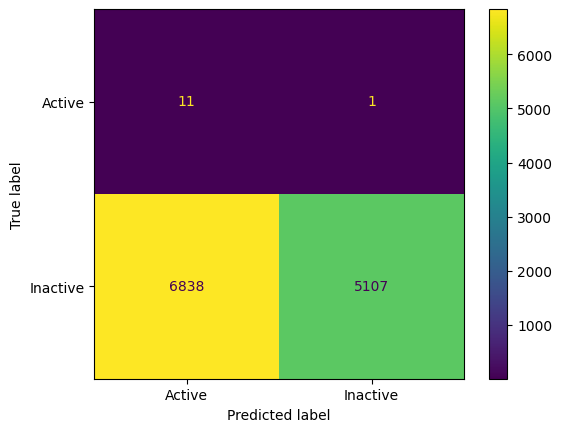

In [28]:
# Sử dụng Random Undersampling để giảm dữ liệu đa số
random_undersampler = RandomUnderSampler()
X_train_random, y_train_random = random_undersampler.fit_resample(X_train_gan, y_train_gan)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, GAN, RandomUnderSamples_',X_train_random,y_train_random,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95562
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 211us/step
| 1         | 0.999     | 0.1526    | 0.04516   |
374/374 [==============================] - 0s 233us/step
| 2         | 0.999     | 0.2267    | 0.01788   |
374/374 [==============================] - 0s 235us/step
| 3         | 0.999     | 0.3183    | 0.04439   |
374/374 [==============================] - 0s 256us/step
| 4         | 0.999     | 0.2743    | 0.03691   |
374/374 [==============================] - 0s 255us/step
| 5         | 0.999     | 0.1065    | 0.01676   |
374/374 [==============================] - 0s 256us/step
| 6         | 0.999     | 0.4997    | 0.09998   |
374/374 [==============================] - 0s 236us/step
| 7         | 0.999     | 0.4994    | 0.09949   |
374/374 [==============================] - 0s 230us/step
| 8         | 0.999     | 0.3511    | 0.013

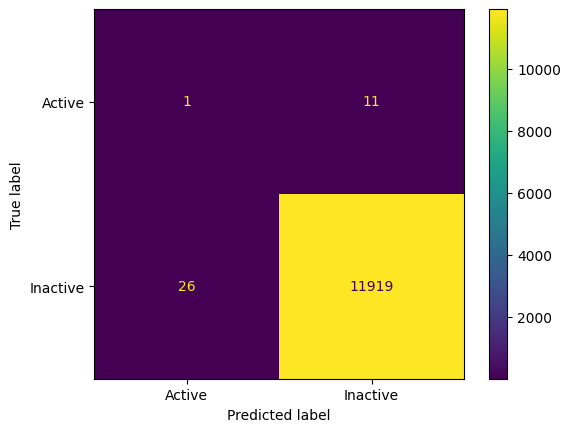

In [29]:
# Áp dụng phương pháp SMOTETomek
smotetomek = SMOTETomek(random_state=42)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_gan, y_train_gan)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, GAN, SMOTETomek_',X_train_smotetomek,y_train_smotetomek,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

Số lượng mẫu sau khi resample để huấn luyện: 95579
|   iter    |  target   | dropou... | learni... |
-------------------------------------------------
374/374 [==============================] - 0s 206us/step
| 1         | 0.999     | 0.3101    | 0.09594   |
374/374 [==============================] - 0s 208us/step
| 2         | 0.999     | 0.3164    | 0.09847   |
374/374 [==============================] - 0s 210us/step
| 3         | 0.999     | 0.3783    | 0.05898   |
374/374 [==============================] - 0s 210us/step
| 4         | 0.999     | 0.2847    | 0.01421   |
374/374 [==============================] - 0s 210us/step
| 5         | 0.999     | 0.2565    | 0.06636   |
374/374 [==============================] - 0s 209us/step
| 6         | 0.999     | 0.1       | 0.007152  |
374/374 [==============================] - 0s 671us/step
| 7         | 0.999     | 0.4998    | 0.002716  |
374/374 [==============================] - 0s 332us/step
| 8         | 0.999     | 0.4483    | 0.068

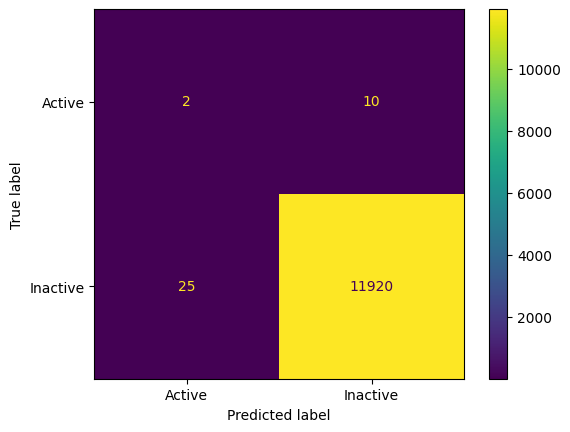

In [30]:
# Sử dụng ADASYN để tăng cường dữ liệu thiểu số
adasyn = ADASYN()
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_gan,y_train_gan)
estimator,metric,npred = resampleBOLang('DeepLearning, BO, GAN, ADASYN_',X_train_adasyn,y_train_adasyn,X_test_mms,y_test)
row = [estimator,metric[0],metric[1],metric[2],metric[3],metric[4],metric[5],npred[0],npred[1],npred[2],npred[3]]
results.append(row)

In [31]:
filename = os.path.basename(path) + '_Keras'
with open(filename + '.csv', "w") as file:
    writer = csv.writer(file, delimiter=",")
    writer.writerow(['Phương pháp tiếp cận','Precision','G-mean','AUC','Accuracy','Recall','F1-score','Active: Đoán đúng','Active: Đoán nhầm','Inactive: Đoán đúng','Inactive: Đoán nhầm'])
    for row in results:
        writer.writerow(row)
file.close()

df = pd.read_csv(filename + '.csv')
df.to_excel(filename + '.xlsx', index=False)